## Binary Classification for Bank Customer Churn Prediction

**Objective**

Predict whether a customer will continue using their account or close it (i.e., whether churn will occur) based on information about bank customers.

**Steps**

1. Prepare Categorical and Numerical Features to ensure they are suitable for the Machine Learning model.
2. Make a Logistic Regression Classifier.
3. Construct a Predictive Pipeline that integrates the preprocessing steps and the logistic regression classifier
4. Evaluate the quality of the model using appropriate metrics
5. Save the Trained Model.

**Dataset**

Download the dataset from Google Drive:

* train set: https://drive.google.com/file/d/1fSdfrwt8B5aQ4H2CIpZMkhNUrz9Ii13i/view?usp=drive_link

* test set: https://drive.google.com/file/d/1DIgalnGEA6xRpQl1st3jAe_ZdqdM7SCF/view?usp=sharing

In [1]:
# Import libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline
import operator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import f1_score, roc_curve, confusion_matrix, auc, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import joblib
from IPython.display import display

Downloading...
From: https://drive.google.com/uc?id=1fSdfrwt8B5aQ4H2CIpZMkhNUrz9Ii13i
To: /content/train.csv
100% 1.25M/1.25M [00:00<00:00, 23.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DIgalnGEA6xRpQl1st3jAe_ZdqdM7SCF
To: /content/test.csv
100% 802k/802k [00:00<00:00, 19.9MB/s]
Class Labels in Train Set
 Exited
0.0    0.7965
1.0    0.2035
Name: proportion, dtype: float64 

Class Labels in Validation Set
 Exited
0.0    0.796667
1.0    0.203333
Name: proportion, dtype: float64 

Column type: input. ['Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Column type: numeric. ['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Column type: categorical. ['Geography', 'Gender']
Target. Exited
Area under ROC score on Train dataset: 88.09%



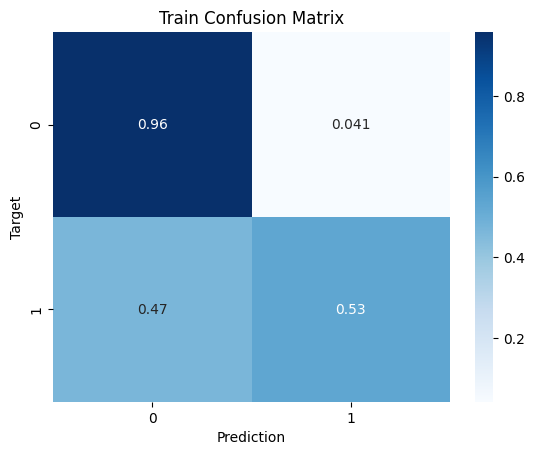

Area under ROC score on Validation dataset: 87.96%



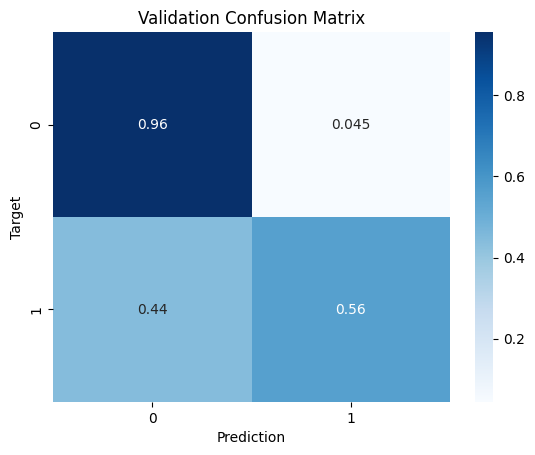

['bank_churn_model.joblib']

In [2]:
# Download dataset from the shared link to Google Drive
train_file_id = '1fSdfrwt8B5aQ4H2CIpZMkhNUrz9Ii13i'
test_file_id = '1DIgalnGEA6xRpQl1st3jAe_ZdqdM7SCF'

train_file_name = 'train.csv'
test_file_name = 'test.csv'
!gdown {train_file_id} -O {train_file_name}
!gdown {test_file_id} -O {test_file_name}

# Read data to a dataframe

raw_df=pd.read_csv(train_file_name, index_col = 0)

# Split into train and validation sets

train_df, val_df = train_test_split(raw_df, test_size = 0.2, random_state = 12, stratify = raw_df.Exited )
print('Class Labels in Train Set\n',train_df.Exited.value_counts(normalize = True),'\n')
print('Class Labels in Validation Set\n',val_df.Exited.value_counts(normalize = True), '\n')

# Create a list of input and target columns

input_cols = train_df.columns.tolist()[:-1]
target_col = train_df.columns.tolist()[-1]

# Identify numeric and categorical columns

numeric_cols = train_df.select_dtypes(include = np.number).columns.tolist()[:-1]
categorical_cols = train_df.select_dtypes(include = 'object').columns.tolist()

# Remove irrelevant columns

def del_cols(col_list, delete_cols, name):

    for col in delete_cols:
      if col in col_list:
        col_list.remove(col)
    print(f'Column type: {name}. {col_list}')

    return col_list

# Form the final column list

delete_cols = ['id', 'CustomerId', 'Surname','CreditScore']
del_cols(input_cols, delete_cols, 'input')
del_cols(numeric_cols, delete_cols, 'numeric')
del_cols(categorical_cols, delete_cols, 'categorical')
print(f'Target. {target_col}')

# Create training and validation datasets

train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# Create transformers for numeric and categorical columns

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Combining transformers for different column types into one preprocessor

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create pipeline for preprocessing data and training model

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train pipeline

model_pipeline.fit(train_inputs, train_targets)

# Predict and evaluate metrics

def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)

    # Predict probabilities
    pred_proba = model_pipeline.predict_proba(inputs)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, pred_proba, pos_label=1)

    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2%}\n")

    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')

    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds, pred_proba

# Evaluate model on train and validation sets

train_preds, train_proba = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds, val_proba = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Save the model

joblib.dump(model_pipeline, 'bank_churn_model.joblib')

## Adding polynomial features.

Let's include the generation of polynomial features up to the second degree in the preprocessing of numerical columns and evaluate the results.

In [3]:
# Create and train pipeline with polynomial model

def create_and_fit_polynomial_pipeline(deg, numeric_cols, categorical_cols, train_inputs, train_targets, type):

  numeric_transformer = Pipeline(steps=[
      ('scaler', MinMaxScaler()),
      ('poly_features', PolynomialFeatures(degree = deg))
  ])

  categorical_transformer = Pipeline(steps=[
      ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'))
  ])

  preprocessor = ColumnTransformer(
      transformers=[
          ('num', numeric_transformer, numeric_cols),
          ('cat', categorical_transformer, categorical_cols)
      ])

  if type == 'log':

     model_pipeline = Pipeline(steps=[
         ('preprocessor', preprocessor),
         ('classifier', LogisticRegression(solver='liblinear'))
     ])
  else:

     model_pipeline = Pipeline(steps=[
         ('preprocessor', preprocessor),
         ('solver', LinearRegression())
     ])

  model_pipeline.fit(train_inputs, train_targets)

  return model_pipeline

In [4]:
model_pipeline_poly2 = create_and_fit_polynomial_pipeline(2, numeric_cols, categorical_cols, train_inputs, train_targets, 'log')

Area under ROC score on Train dataset: 92.10%



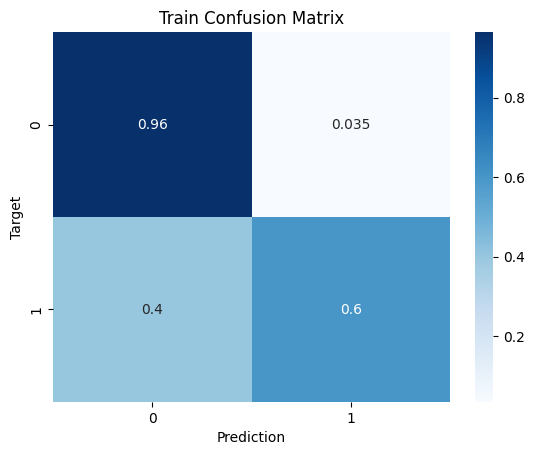

Area under ROC score on Validation dataset: 92.08%



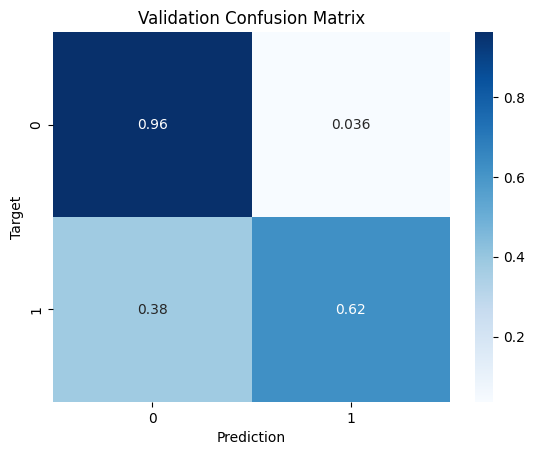

In [5]:
# Make predictions on train and validation datasets

train_preds_poly2, train_proba_poly2 = predict_and_plot(model_pipeline_poly2, train_inputs, train_targets, 'Train')
val_preds_poly2, val_proba_poly2 = predict_and_plot(model_pipeline_poly2, val_inputs, val_targets, 'Validation')

**Conclusions**

1. The model with polynomial features performs better than linear regression (AUROC on the validation set is 92.08% compared to 87.96%).

1. In my opinion, the model with the second-degree polynomial features generalizes well. There is no underfitting. There is also no overfitting (the AUROC on the validation set is nearly equal to that on the training set: 92.08% on validation versus 92.1% on training).

Now let's try generating polynomial features up to the fourth degree inclusive and evaluate the results.

In [6]:
# Train model with polynomial features up to 4th degree

model_pipeline_poly4 = create_and_fit_polynomial_pipeline(4, numeric_cols, categorical_cols, train_inputs, train_targets, 'log')

Area under ROC score on Train dataset: 93.19%



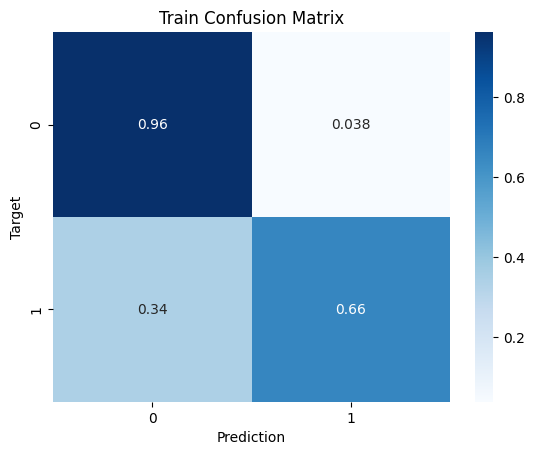

Area under ROC score on Validation dataset: 92.97%



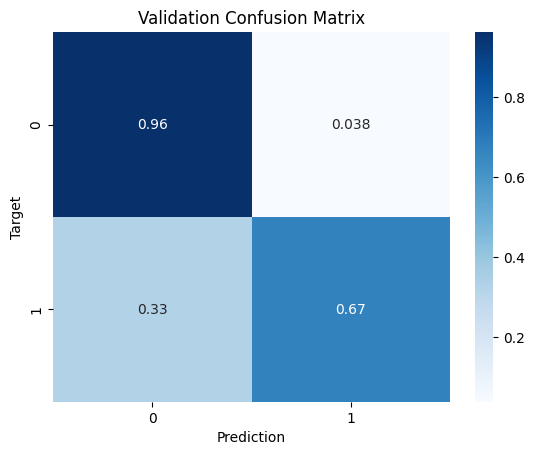

In [7]:
# Make predictions on train and validation sets

train_preds_poly4, train_proba_poly4 = predict_and_plot(model_pipeline_poly4, train_inputs, train_targets, 'Train')
val_preds_poly4, val_proba_poly4 = predict_and_plot(model_pipeline_poly4, val_inputs, val_targets, 'Validation')

In [8]:
# Download test data

test_raw_df = pd.read_csv(test_file_name)

# Make predictions on test data

submission_df = pd.DataFrame(data = test_raw_df.id, columns = ['id'])

submission_df['Exited'] = model_pipeline_poly4.predict_proba(test_raw_df[input_cols])[:,1]
submission_df.to_csv('submission_log_reg.csv', index = False)

**Conclusions**

1. The model with 4 polynomial features outperforms the linear model (AUROC on the validation set is 92.97% compared to 87.96%) and shows similar performance to the model with 2 polynomial features (AUROC on the validation set is 92.97% with 4 features and 92.08% on the training set).

1. In my opinion, the model with 4 polynomial features generalizes well. There is no underfitting. There is also no significant overfitting (the AUROC on the validation dataset is lower than on the training dataset, but only slightly: 92.97% on the validation set compared to 93.19% on the training set).